In [23]:
import sys, os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr

sys.path.append(os.path.join(os.getcwd(), '..', '..'))
from gnt.data.common.geobox import get_or_create_geobox
from odc.geo import CRS
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject

In [29]:
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/_modis_timeseries_reprojected.zarr", mask_and_scale=False)
modis = modis.rio.write_crs(4326)
modis_bangladesh = modis.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).compute()

In [32]:
modis_bangladesh["mean"].squeeze().isel(time=-1)#.plot.imshow()

<xarray.DataArray 'mean' (latitude: 1387, longitude: 1102)> Size: 3MB
array([[28218, 28205, 28205, ...,     0,     0,     0],
       [28206, 28206, 28203, ...,     0,     0,     0],
       [28206, 28203, 28203, ...,     0,     0,     0],
       ...,
       [29593, 29593, 29593, ..., 29311, 29311, 29311],
       [29578, 29578, 29583, ..., 29309, 29309, 29312],
       [29578, 29583, 29583, ..., 29309, 29312, 29312]],
      shape=(1387, 1102), dtype=uint16)
Coordinates:
    band         int64 8B 1
  * latitude     (latitude) float64 11kB 26.45 26.44 26.44 ... 20.68 20.67 20.67
  * longitude    (longitude) float64 9kB 88.08 88.09 88.09 ... 92.66 92.67 92.67
    time         datetime64[ns] 8B 2020-12-31
    spatial_ref  int64 8B 0
Attributes: (12/46)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:  MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:    Terra
    ASSOCIATEDSENSORSHORTNAME.1:      MODIS
    BANDDEFINITION:                   END_OBJECT
    CHARACTERISTICBINSIZE:            926.6
    DATACOLUMNS:                      1200
    ...                               ...
    WESTHBOUNDINGCOORDINATE:          179.85625
    add_offset:                       0.0
    long_name:                        Land surface temperature 1km SIN Grid
    scale_factor:                     0.01
    units:                            K
    _FillValue:                       0

In [10]:
viirs = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr", decode_coords="all")
viirs = viirs.rio.write_crs(4326)
viirs_bangladesh = viirs.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).compute()

In [11]:
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr")
land_mask = land_mask.rio.write_crs(4326)
land_mask_bangladesh = land_mask.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).land_mask.compute()

In [27]:
modis_bangladesh = modis_bangladesh.where(land_mask_bangladesh)
viirs_bangladesh = viirs_bangladesh.where(land_mask_bangladesh)

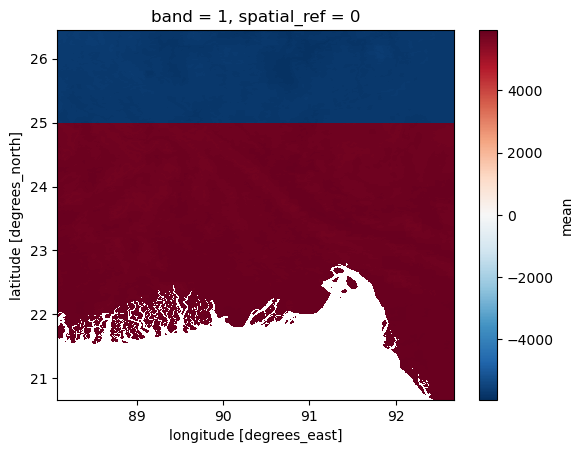

In [13]:
(modis_bangladesh["mean"].sel(time = slice("2010-12-31", "2019-12-31")).mean(dim = "time") - 
 modis_bangladesh["mean"].sel(time = slice("2000-12-31", "2009-12-31")).mean(dim = "time")).squeeze().plot.imshow()

/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


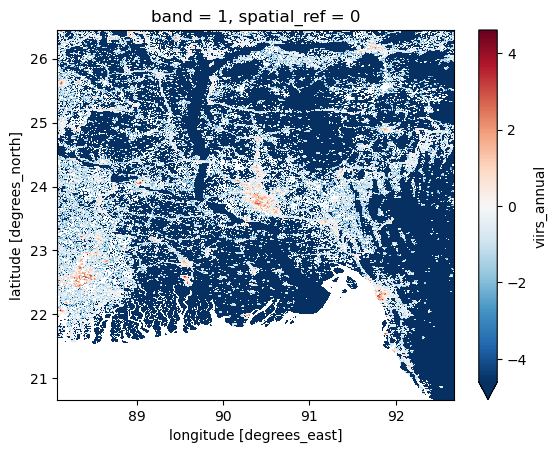

In [7]:
np.log(viirs_bangladesh["viirs_annual"].sel(time = "2020-12-31", band = 1) - viirs_bangladesh["viirs_annual"].sel(time = "2013-12-31", band = 1) + 0.01).plot.imshow(robust = True)

In [8]:
viirs_bangladesh

<xarray.Dataset> Size: 61MB
Dimensions:       (time: 10, band: 1, latitude: 1387, longitude: 1102)
Coordinates:
  * band          (band) int64 8B 1
  * latitude      (latitude) float64 11kB 26.45 26.44 26.44 ... 20.67 20.67
  * longitude     (longitude) float64 9kB 88.08 88.09 88.09 ... 92.67 92.67
  * time          (time) datetime64[ns] 80B 2012-12-31 2013-12-31 ... 2021-12-31
    spatial_ref   int64 8B 0
Data variables:
    viirs_annual  (time, band, latitude, longitude) float32 61MB 0.2089 ... 0.0

In [9]:
merged = xr.combine_by_coords(
    [
        modis_bangladesh["mean"].squeeze(),
        viirs_bangladesh["viirs_annual"].squeeze()
    ],
    combine_attrs="override"
)

In [10]:
merged_df = merged.to_dataframe().dropna()

In [14]:
merged_df

band  spatial_ref   mean  viirs_annual
latitude  longitude time                                              
26.445833 88.083335 2012-12-31     1            0  282.0      0.208900
                    2013-12-31     1            0  282.0      0.000000
                    2014-12-31     1            0  282.0      0.000000
                    2015-12-31     1            0  282.0      0.408697
                    2016-12-31     1            0  282.0      0.000000
...                              ...          ...    ...           ...
20.670833 92.670836 2016-12-31     1            0  293.0      0.000000
                    2017-12-31     1            0  293.0      0.000000
                    2018-12-31     1            0  293.0      0.000000
                    2019-12-31     1            0  294.0      0.000000
                    2020-12-31     1            0  293.0      0.000000

[11019564 rows x 4 columns]

<Axes: xlabel='mean', ylabel='viirs_annual'>

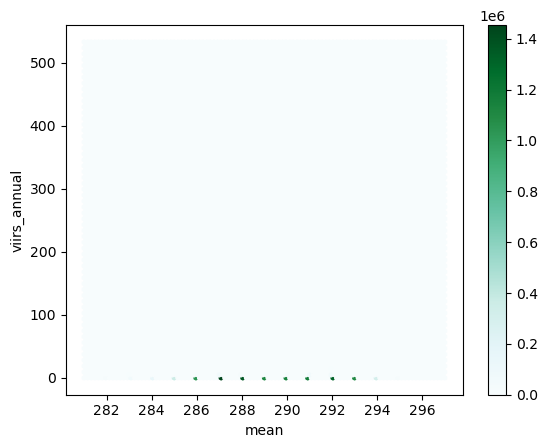

In [13]:
merged_df[["mean", "viirs_annual"]].plot(x = "mean", y = "viirs_annual", kind = "hexbin")